# Proyecto 1.1 BI 

Integrantes:
-Maria Fernanda De La Hoz
-Silvana Sandoval 
-Gabriela Soler 

## Preprocesamiento y análisis de datos

### Instalación de spaCy y Modelos de lenguaje

In [1]:
!pip install spacy
!python -m spacy download es_core_news_md


     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     --------------------------------------- 0.0/42.3 MB 495.5 kB/s eta 0:01:26
     ---------------------------------------- 0.2/42.3 MB 1.3 MB/s eta 0:00:33
     ---------------------------------------- 0.3/42.3 MB 1.8 MB/s eta 0:00:24
      --------------------------------------- 0.9/42.3 MB 4.0 MB/s eta 0:00:11
     - -------------------------------------- 1.6/42.3 MB 5.9 MB/s eta 0:00:07
     - -------------------------------------- 2.1/42.3 MB 6.6 MB/s eta 0:00:07
     -- ------------------------------------- 2.5/42.3 MB 7.2 MB/s eta 0:00:06
     -- ------------------------------------- 3.1/42.3 MB 7.5 MB/s eta 0:00:06
     --- ------------------------------------ 3.9/42.3 MB 8.5 MB/s eta 0:00:05
     ---- ----------------------------------- 4.4/42.3 MB 9.0 MB/s eta 0:00:05
     ---- ----------------------------------- 4.6/42.3 MB 8.9 MB/

### Importación de las librerias pertinentes

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin


### Carga del modelo de lenguaje

In [3]:
import spacy
nlp = spacy.load("es_core_news_md") #En este caso cargamos el modelo de lenguaje español

### Lectura de datos 

In [4]:
import pandas as pd

data = pd.read_excel("ODScat_345.xlsx")

## Entendimiento de los datos

In [5]:
print(data.sample(5))
print("Total de registros: ", data.shape[0])

                                         Textos_espanol  sdg
875   Cuando se considera la utilización de servicio...    3
1449  Rumania utiliza una combinación de tipos de ev...    4
265   Actualmente, los asistentes médicos, que están...    3
2354  En las regiones en desarrollo, una proporción ...    5
943   Como se discutió en el Capítulo 2, hay margen ...    3
Total de registros:  4049


Se tienen 4049 opiniones de ciudadanos y hay 2 variables: la primera corresponde a la variable Textos_espanol, que es una cadena de caracteres y es la opinión de los ciudadanos. La segunda variable es sdg, que es la variable objetivo, es decir, el ODS correspondiente.

### Unicidad

In [6]:
print("Duplicados: ", data.duplicated().sum())

Duplicados:  0


### Completitud

In [7]:
print(data.isnull().sum())

Textos_espanol    0
sdg               0
dtype: int64


### Validez

In [8]:
data.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [9]:
data.dtypes

Textos_espanol    object
sdg                int64
dtype: object

## Preprocesamiento del texto

In [10]:
# Aplicar spaCy a la columna de opiniones en español
dataCopy = data.copy()
dataCopy['procesado'] = dataCopy['Textos_espanol'].apply(lambda x: nlp(x))
dataCopy[['Textos_espanol', 'procesado']].head()

,Textos_espanol,procesado
0,"Por ejemplo, el nÃºmero de consultas externas ...","(Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...","(En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...","(Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...","(Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","(El, consumo, anual, de, alcohol, se, estima, ..."


### Tokenización

In [11]:
dataCopy['tokens'] = dataCopy['procesado'].apply(lambda doc: [token.text for token in doc])
dataCopy[['Textos_espanol', 'tokens']].head()

,Textos_espanol,tokens
0,"Por ejemplo, el nÃºmero de consultas externas ...","[Por, ejemplo, ,, el, nÃºmero, de, consultas, ..."
1,"En 2007, el gobierno central financió directam...","[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...","[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...","[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[El, consumo, anual, de, alcohol, se, estima, ..."


### Lematización-Obtener la forma base de las palabras

In [12]:
dataCopy['lemmas'] = dataCopy['procesado'].apply(lambda doc: [token.lemma_ for token in doc])
dataCopy[['Textos_espanol', 'lemmas']].head()

,Textos_espanol,lemmas
0,"Por ejemplo, el nÃºmero de consultas externas ...","[por, ejemplo, ,, el, nãºmero, de, consulta, e..."
1,"En 2007, el gobierno central financió directam...","[en, 2007, ,, el, gobierno, central, financiar..."
2,"Claramente, hay muchos otros factores en juego...","[claramente, ,, haber, mucho, otro, factor, en..."
3,"Por ejemplo, el estado australiano de Victoria...","[por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[el, consumo, anual, de, alcohol, él, estimar,..."


### Eliminación de stopWords

In [13]:
dataCopy['lemmas_sin_stopwords'] = dataCopy['procesado'].apply(lambda doc: [token.lemma_ for token in doc if not token.is_stop])
dataCopy[['Textos_espanol', 'lemmas_sin_stopwords']].head()

,Textos_espanol,lemmas_sin_stopwords
0,"Por ejemplo, el nÃºmero de consultas externas ...","[ejemplo, ,, nãºmero, consulta, externo, espec..."
1,"En 2007, el gobierno central financió directam...","[2007, ,, gobierno, central, financiar, direct..."
2,"Claramente, hay muchos otros factores en juego...","[claramente, ,, factor, juego, ,, particular, ..."
3,"Por ejemplo, el estado australiano de Victoria...","[ejemplo, ,, australiano, Victoria, crear, age..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[consumo, anual, alcohol, estimar, 15.7, litro..."


### Filtrado de caracteres especiales

In [14]:
dataCopy['lemmas_limpios'] = dataCopy['lemmas_sin_stopwords'].apply(lambda lemmas: [lemma for lemma in lemmas if lemma.isalpha()])
dataCopy[['Textos_espanol', 'lemmas_limpios']].head()

,Textos_espanol,lemmas_limpios
0,"Por ejemplo, el nÃºmero de consultas externas ...","[ejemplo, nãºmero, consulta, externo, especial..."
1,"En 2007, el gobierno central financió directam...","[gobierno, central, financiar, directamente, g..."
2,"Claramente, hay muchos otros factores en juego...","[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...","[ejemplo, australiano, Victoria, crear, agenci..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[consumo, anual, alcohol, estimar, litro, año,..."


### Entidades resultantes

In [15]:
dataCopy['entidades'] = dataCopy['procesado'].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents])
dataCopy[['Textos_espanol', 'entidades']].head()

,Textos_espanol,entidades
0,"Por ejemplo, el nÃºmero de consultas externas ...","[(nÃºmero, MISC), (SP, ORG), (comparaciÃ³n, LO..."
1,"En 2007, el gobierno central financió directam...","[(La mayor parte, MISC), (El gobierno provinci..."
2,"Claramente, hay muchos otros factores en juego...","[(Por ejemplo, MISC), (Por lo tanto, MISC), (L..."
3,"Por ejemplo, el estado australiano de Victoria...","[(Victoria, LOC), (EE.UU., LOC), (California, ..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[(OCDE, ORG), (OMS, ORG), (Si bien la prevalen..."


### Clasificación de palabras

In [16]:
dataCopy['pos_tags'] = dataCopy['procesado'].apply(lambda doc: [(token.text, token.pos_) for token in doc])
dataCopy[['Textos_espanol', 'pos_tags']].head()

,Textos_espanol,pos_tags
0,"Por ejemplo, el nÃºmero de consultas externas ...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,..."
1,"En 2007, el gobierno central financió directam...","[(En, ADP), (2007, NOUN), (,, PUNCT), (el, DET..."
2,"Claramente, hay muchos otros factores en juego...","[(Claramente, ADV), (,, PUNCT), (hay, AUX), (m..."
3,"Por ejemplo, el estado australiano de Victoria...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,..."
4,"El consumo anual de alcohol se estima en 15,7 ...","[(El, DET), (consumo, NOUN), (anual, ADJ), (de..."


### Texto preprocesado Final

In [17]:
dataCopy['texto_preprocesado'] = dataCopy['lemmas_limpios'].apply(lambda lemmas: ' '.join(lemmas))
dataCopy[['Textos_espanol', 'texto_preprocesado']].head()

,Textos_espanol,texto_preprocesado
0,"Por ejemplo, el nÃºmero de consultas externas ...",ejemplo nãºmero consulta externo especialista ...
1,"En 2007, el gobierno central financió directam...",gobierno central financiar directamente gasto ...
2,"Claramente, hay muchos otros factores en juego...",claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",ejemplo australiano Victoria crear agencia pro...
4,"El consumo anual de alcohol se estima en 15,7 ...",consumo anual alcohol estimar litro año hombre...


### Guardar datos

In [18]:

dataCopy.to_excel("datos_preprocesados.xlsx", index=False)
print("Los datos preprocesados fueron cargados exitosamente")


Los datos preprocesados fueron cargados exitosamente


### Visualización palabras más frecuentes por ODS

In [19]:
!pip install matplotlib seaborn wordcloud


   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   -- ------------------------------------ 20.5/301.4 kB 330.3 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/301.4 kB 393.8 kB/s eta 0:00:01
   --------------------------------- ------ 256.0/301.4 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 2.1 MB/s eta 0:00:00


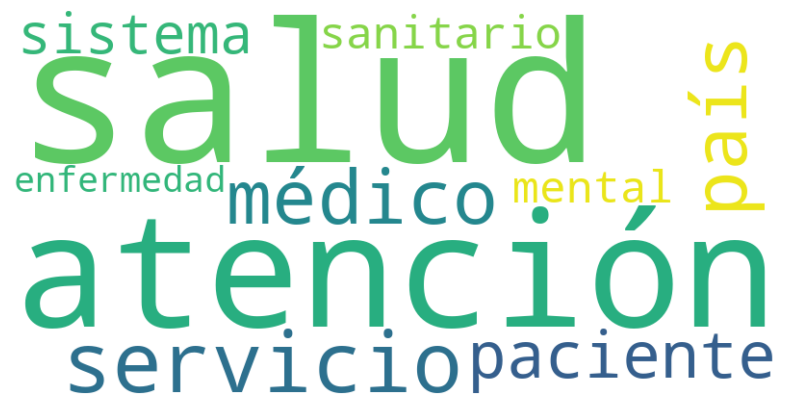

C:\Users\silva\AppData\Local\Temp\ipykernel_24260\3778387794.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_frecuencia, palette='viridis')


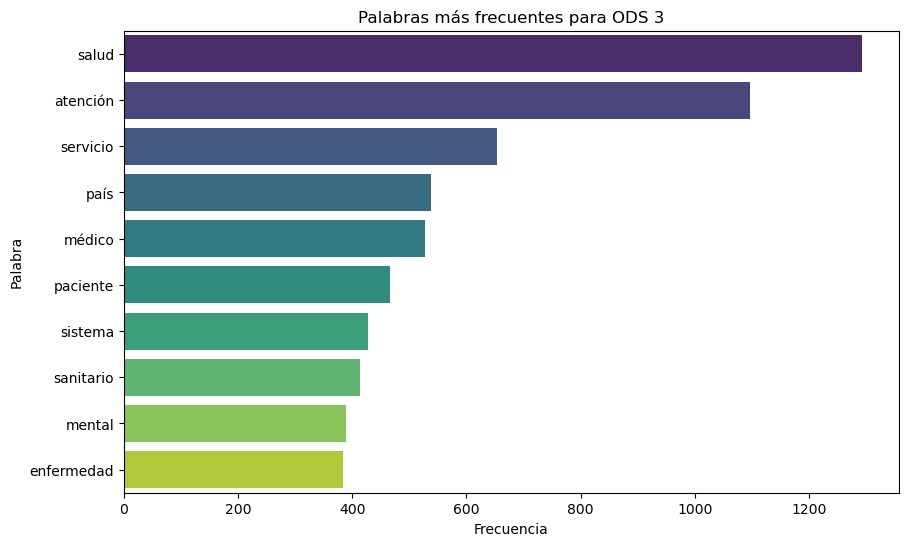

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

def palabras_frecuentes_por_ods(df, columna_lemmas, ods_numero, top_n=10):
    df_ods = df[df['sdg'] == ods_numero]
    todos_los_lemmas = df_ods[columna_lemmas].explode() 
    contador = Counter(todos_los_lemmas)
    palabras_mas_frecuentes = contador.most_common(top_n)
    return pd.DataFrame(palabras_mas_frecuentes, columns=['Palabra', 'Frecuencia'])

def mostrar_nube_palabras(df_frecuencia):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(df_frecuencia.values))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def mostrar_grafico_barras(df_frecuencia, ods_numero):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frecuencia', y='Palabra', data=df_frecuencia, palette='viridis')
    plt.title(f'Palabras más frecuentes para ODS {ods_numero}')
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabra')
    plt.show()

df_frecuencia_ods3 = palabras_frecuentes_por_ods(dataCopy, 'lemmas_limpios', 3)
mostrar_nube_palabras(df_frecuencia_ods3)
mostrar_grafico_barras(df_frecuencia_ods3, 3)


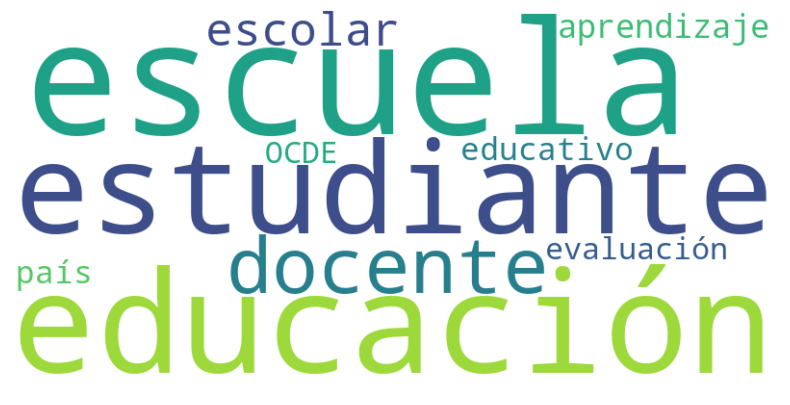

C:\Users\silva\AppData\Local\Temp\ipykernel_24260\3778387794.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_frecuencia, palette='viridis')


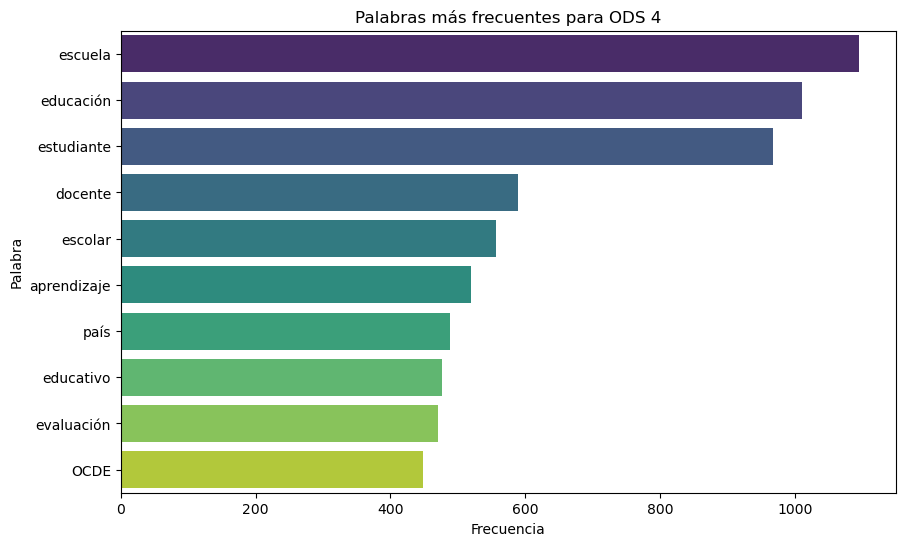

In [21]:
df_frecuencia_ods4 = palabras_frecuentes_por_ods(dataCopy, 'lemmas_limpios', 4)
mostrar_nube_palabras(df_frecuencia_ods4)
mostrar_grafico_barras(df_frecuencia_ods4, 4)

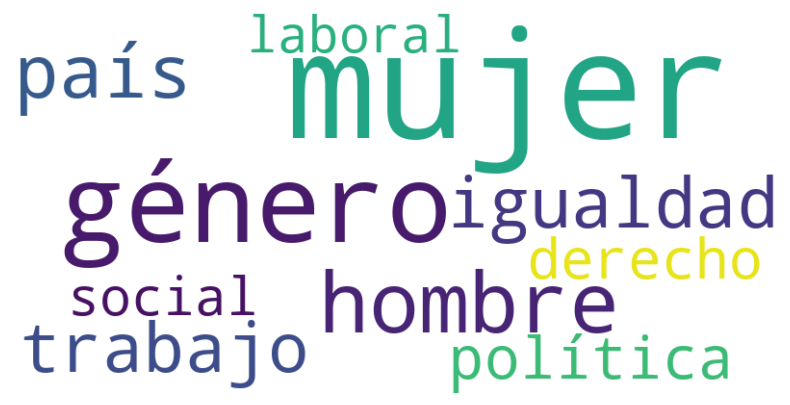

C:\Users\silva\AppData\Local\Temp\ipykernel_24260\3778387794.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=df_frecuencia, palette='viridis')


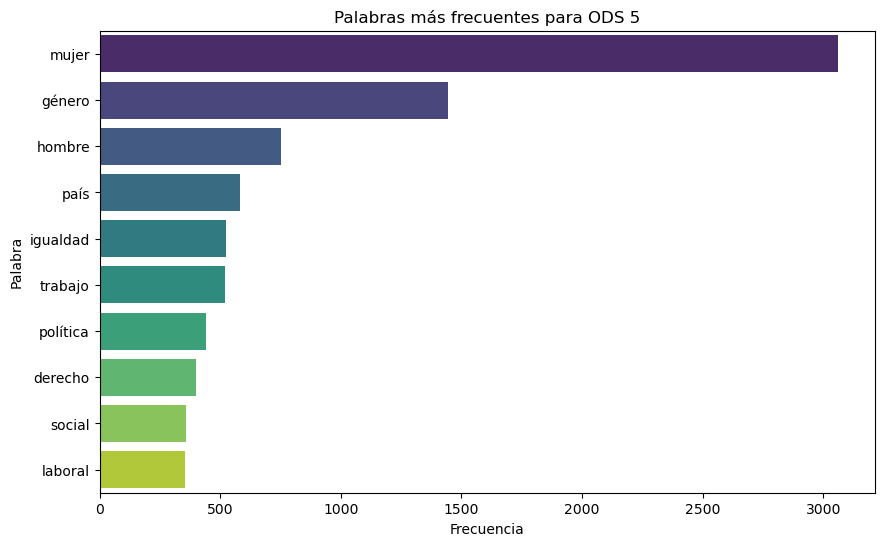

In [22]:
df_frecuencia_ods5 = palabras_frecuentes_por_ods(dataCopy, 'lemmas_limpios', 5)
mostrar_nube_palabras(df_frecuencia_ods5)
mostrar_grafico_barras(df_frecuencia_ods5, 5)

## Transformación

### 1. Term Frequency Inverse Document Frequency

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(dataCopy['texto_preprocesado']).toarray()

### 2. Count Vectorizer

In [24]:
count = CountVectorizer(max_features=1000)
X_count = count.fit_transform(dataCopy['texto_preprocesado'])
print(X_count.shape)
X_count.toarray()[0]

(4049, 1000)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 3. Count Vectorizer Binario

In [25]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(dataCopy['texto_preprocesado'])
print(X_dummy.shape)
X_dummy.toarray()[0]

(4049, 12420)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Division para train y validation

Primero, hacemos la división del conjunto de datos codificados con TD-IDF en los datos para train y validation. Con esto nos aseguramos de tener un conjunto de validation para asegurarnos de que el algoritmo prediga correctamente las categorias.

In [26]:
dataCopy.head()

,Textos_espanol,sdg,procesado,tokens,lemmas,lemmas_sin_stopwords,lemmas_limpios,entidades,pos_tags,texto_preprocesado
0,"Por ejemplo, el nÃºmero de consultas externas ...",3,"(Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[Por, ejemplo, ,, el, nÃºmero, de, consultas, ...","[por, ejemplo, ,, el, nãºmero, de, consulta, e...","[ejemplo, ,, nãºmero, consulta, externo, espec...","[ejemplo, nãºmero, consulta, externo, especial...","[(nÃºmero, MISC), (SP, ORG), (comparaciÃ³n, LO...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,...",ejemplo nãºmero consulta externo especialista ...
1,"En 2007, el gobierno central financió directam...",3,"(En, 2007, ,, el, gobierno, central, financió,...","[En, 2007, ,, el, gobierno, central, financió,...","[en, 2007, ,, el, gobierno, central, financiar...","[2007, ,, gobierno, central, financiar, direct...","[gobierno, central, financiar, directamente, g...","[(La mayor parte, MISC), (El gobierno provinci...","[(En, ADP), (2007, NOUN), (,, PUNCT), (el, DET...",gobierno central financiar directamente gasto ...
2,"Claramente, hay muchos otros factores en juego...",3,"(Claramente, ,, hay, muchos, otros, factores, ...","[Claramente, ,, hay, muchos, otros, factores, ...","[claramente, ,, haber, mucho, otro, factor, en...","[claramente, ,, factor, juego, ,, particular, ...","[claramente, factor, juego, particular, varied...","[(Por ejemplo, MISC), (Por lo tanto, MISC), (L...","[(Claramente, ADV), (,, PUNCT), (hay, AUX), (m...",claramente factor juego particular variedad ba...
3,"Por ejemplo, el estado australiano de Victoria...",3,"(Por, ejemplo, ,, el, estado, australiano, de,...","[Por, ejemplo, ,, el, estado, australiano, de,...","[por, ejemplo, ,, el, estado, australiano, de,...","[ejemplo, ,, australiano, Victoria, crear, age...","[ejemplo, australiano, Victoria, crear, agenci...","[(Victoria, LOC), (EE.UU., LOC), (California, ...","[(Por, ADP), (ejemplo, NOUN), (,, PUNCT), (el,...",ejemplo australiano Victoria crear agencia pro...
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"(El, consumo, anual, de, alcohol, se, estima, ...","[El, consumo, anual, de, alcohol, se, estima, ...","[el, consumo, anual, de, alcohol, él, estimar,...","[consumo, anual, alcohol, estimar, 15.7, litro...","[consumo, anual, alcohol, estimar, litro, año,...","[(OCDE, ORG), (OMS, ORG), (Si bien la prevalen...","[(El, DET), (consumo, NOUN), (anual, ADJ), (de...",consumo anual alcohol estimar litro año hombre...


In [27]:
y = dataCopy["sdg"]
X_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=10)
X_train_count, x_validation2_count, y_train2_count, y_validation2_count = train_test_split(X_count, y, test_size=0.3, random_state=10)
X_train_dummy, x_validation_dummy, y_train_dummy, y_validation_dummy = train_test_split(X_dummy, y, test_size=0.3, random_state=10)


## Búsqueda de hiperparámetros para el Árbol de Decisión

In [28]:
decision_tree = DecisionTreeClassifier(random_state=0)

Los siguientes parámetros se usaran para realizar la busqueda de los mejores hiperparámetros para este conjunto de datos.

In [29]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [2, 4, 6, 8, 10, 12, 18],
              'min_samples_split': [2, 3, 5, 10, 12]}

Además, para asegurarnos de escoger la mejor opción posible, usaremos un objeto KFold() para realizar validación cruzada con 15 subconjuntos de los datos

In [30]:
kfold = KFold(n_splits=15, shuffle= True, random_state=0)

Por último, haremos la búsqueda de los mejores parametros con un objeto GridSearchCV(). Esta se realizará con un n_jobs = -1 ya que deseamos que todos los procesadores sean usados para la busqueda de los hiperparámetros.

In [31]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

Ejecutaremos la búsqueda de los hiperparámetros

In [32]:
grid.fit(X_train, y_train)
#Revisar si tenemos x_train y y_train. Al no tenerlos, preguntar si vamos a usar una pipeline para tener los datos listos

GridSearchCV(cv=KFold(n_splits=15, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 18],
                         'min_samples_split': [2, 3, 5, 10, 12]})

Se obtendran los mejores valores para los hiperparámetros

In [33]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 12}


Se obtendrá el mejor modelo para el Árbol de Decisión

In [34]:
best_tree = grid.best_estimator_

## Busqueda de los mejores hiperparámetros para Naïve Bayes

In [35]:
nb = MultinomialNB()

Para buscar los mejores hiperparámetros para Naïve Bayes, se decidió usar "alpha", que es el parámetro de suavización de Laplce, el cual controla la regularización añadiendo un valor positivo a los conteos y así evitar probabilidades cero. 

In [36]:
param_gridNB = { 'alpha': [0.1, 0.5, 1.0, 2.0]}

Luego, se genera la búsqueda del mejor parámetro con GridSearchCV, que explora la lista de combinaciones posibles de valores para cada hiperparámetro. Posteriormente, se realiza la búsqueda de los hiperparámetros y se obtiene el mejor para poder tener el mejor modelo de Multinomial Naïve Bayes. 

In [37]:
grid_searchNB = GridSearchCV(estimator=nb, param_grid=param_gridNB, scoring='accuracy')
grid_searchNB.fit(X_train, y_train)
print("Mejores parámetros: {}".format(grid_searchNB.best_params_))
best_NB = grid_searchNB.best_estimator_

Mejores parámetros: {'alpha': 2.0}


## Busqueda de los mejores hiperparámetros para K-Vecinos

Para escoger el mejor hiperparámetro para K-Vecinos, utilizaremos la función GridSearch

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Definir los valores posibles de k
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)


print(f"Mejor valor de k: {grid_search.best_params_}")


Mejor valor de k: {'n_neighbors': 11}


In [39]:
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=11) 

knn.fit(X_train, y_train)
y_pred1 = knn.predict(x_validation)

## Evaluación de los modelos

### Evaluación mejor modelo Árbol de Decisión

Se realizaran predicciones sobre el conjunto de validación que se separó antes de crear el objeto de árbol de decisión.

In [40]:
y_pred = best_tree.predict(x_validation)

Después, se crea la matriz de confusión que permitirá ver qué tan acertadas son las predicciones del Árbol de Decisión. Esto se hace para tener una representación visual de los aciertos y desaciertos del algoritmo

In [41]:
matriz_confusion = confusion_matrix(y_validation, y_pred, labels=best_tree.classes_)

Se crea un display para poder visualizar la matriz de confusión.

In [42]:
matrix_display = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=best_tree.classes_)

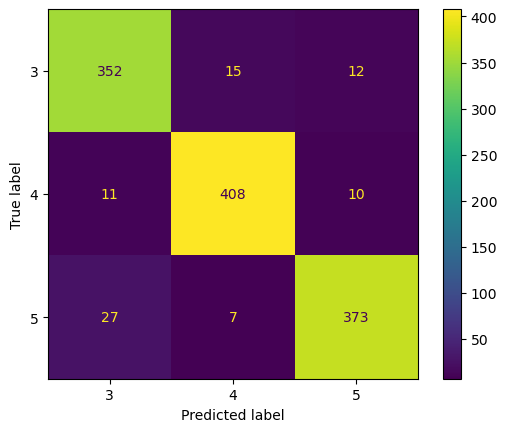

In [43]:
matrix_display.plot()

Esta matriz de confusión muestra que la clase que mejor predice el árbol de decisión es la de ODS 4. Esto se puede asegurar ya que de los 429 datos que verdaderamente son de esta clase, clasificó correctamente 373. Esto implica que estas predicciones tienen un 95% de certeza. Por otro lado, las otras dos clases que clasifica (es decir, ODS 3 y 5) también tienen un alto porcentaje de aciertos. Por parte de la primera, hay un 93% de certeza, mientras que de la otra tiene una certeza del 92%, lo cual implica que es un modelo muy acertado. 

Por último, se hace un classification_report para poder observar la precisión, el recall y el f-score en las predicciones del algoritmo con base en los datos de validación

In [44]:
print(classification_report(y_validation, y_pred))
print('Exactitud: %.2f' % accuracy_score(y_validation, y_pred))

              precision    recall  f1-score   support

           3       0.90      0.93      0.92       379
           4       0.95      0.95      0.95       429
           5       0.94      0.92      0.93       407

    accuracy                           0.93      1215
   macro avg       0.93      0.93      0.93      1215
weighted avg       0.93      0.93      0.93      1215

Exactitud: 0.93


Como se puede observar, la clase que menos presición tiene es el ODS 3, lo cual implica que esta es la clase cuyos datos el árbol con mayor frecuencia tiende a catalogar erroenameante. Sin embargo, el recall de esta clase es el más alto de todas, lo cual implica que lo que se categoriza dentro de la clase tiene una mayor precisión. Es decir, que aquello que el algoritmo, dentro del ODS 3, categoriza como ODS 3 y el resto lo hace con mayor precisión. Por otra parte, para hacer referencia al F-Score, el de las 3 clases es bastante alto, lo cual implica que que tanto la precisión y el recall son buenos.

### Evaluación Mejor Modelo de Naïves Bayes

              precision    recall  f1-score   support

           3       0.97      0.95      0.96       379
           4       0.98      0.97      0.98       429
           5       0.95      0.98      0.97       407

    accuracy                           0.97      1215
   macro avg       0.97      0.97      0.97      1215
weighted avg       0.97      0.97      0.97      1215

Exactitud: 0.968724279835391
Recall: 0.968724279835391
Precisión: 0.9690398461636535
F1-Score: 0.9687382379483958


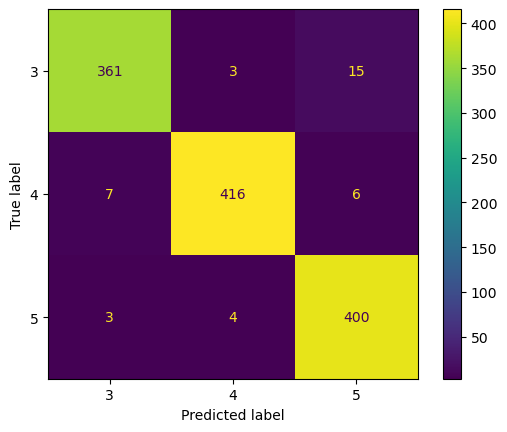

In [45]:
y_pred = best_NB.predict(x_validation)
matriz_confusionNB = confusion_matrix(y_validation, y_pred, labels=best_NB.classes_)
matrix_display_NB = ConfusionMatrixDisplay(confusion_matrix=matriz_confusionNB, display_labels=best_NB.classes_)
matrix_display_NB.plot()

report = classification_report(y_validation, y_pred)
grid_searchNB.best_params_, report
print(report)
print(f"Exactitud: {accuracy_score(y_validation, y_pred)}")
print(f"Recall: {recall_score(y_validation, y_pred, average='weighted')}")
print(f"Precisión: {precision_score(y_validation, y_pred, average='weighted')}")
print(f"F1-Score: {f1_score(y_validation, y_pred, average='weighted')}")

Por medio de la observación de la matriz obtenida y del reporte de clasificación, se puede evidenciar que la clase que mejor predice el modelo de Naïve Bayes corresponde al ODS 4, pues de los 429 datos que pertenecen realmente a esta clase, el modelo clasificó correctamente 416, con una precisión del 98% y un recall del 97%. En general, las métricas obtenidas indican que los datos tienen un excelente rendimiento en la clasificación y tiene una exactitud de aproximadamente 97%. Además, el recall del modelo global también es aproximadamente 97%, lo que indica que, en efecto, el modelo encuentra eficientemente los verdaderos positivos.

### Evaluación mejor modelo de K-Vecinos

In [46]:
accuracy = accuracy_score(y_validation, y_pred1)
print(f"Precisión del modelo: {accuracy}")

print(classification_report(y_validation, y_pred1))

Precisión del modelo: 0.9588477366255144
              precision    recall  f1-score   support

           3       0.96      0.96      0.96       379
           4       0.99      0.95      0.97       429
           5       0.94      0.97      0.95       407

    accuracy                           0.96      1215
   macro avg       0.96      0.96      0.96      1215
weighted avg       0.96      0.96      0.96      1215



Dados los resultados, se puede observar un alto procentanje de precisión en las predicciones del modelo. Siendo el ODS 4 el que tiene un mayor porcentaje. Aunque el modelo se comporta muy bien, sigue teniendo un mejor desempeño ponderado el modelo de Naïves Bayes.

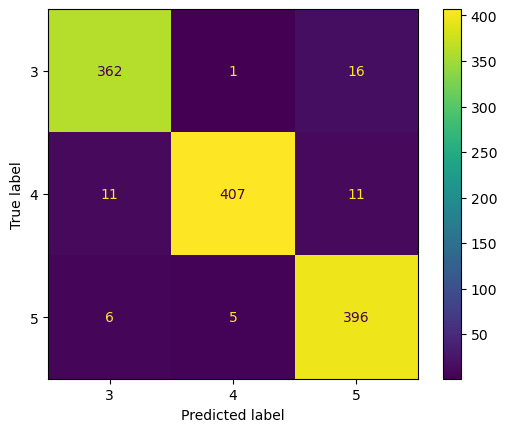

In [47]:
matriz_confusion = confusion_matrix(y_validation, y_pred1, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=knn.classes_)
disp.plot()

## Creación del Pipeline

Creación del encoder

In [48]:
tfidf = TfidfVectorizer()

Ahora, se crearán las clases que se usarán para realizar el prepocesamiento de los textos.

In [53]:
import spacy

class ToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, input_type='csv', column_names=None):
        """
        Custom transformer to load data from CSV or text and convert it into a DataFrame.
        
        Parameters:
        - input_type: 'csv' or 'text' to specify the type of input.
        - column_names: List of column names (required for text input).
        """
        self.input_type = input_type
        self.column_names = column_names
    
    def fit(self, X=None, y=None):
        # No fitting needed, just return self
        return self
    
    def transform(self, X):
        """
        Transforms the input (either a file path or text) into a DataFrame.
        
        X can be:
        - A CSV file path if input_type='csv'
        - A raw text input if input_type='text'
        """
        if self.input_type == 'csv':
            # Check if X is a valid file path
            if not os.path.isfile(X):
                raise ValueError(f"The file {X} does not exist.")
            
            # Load CSV into a DataFrame
            df = pd.read_csv(X)
        
        elif self.input_type == 'text':
            # Ensure column names are provided for text input
            if not self.column_names:
                raise ValueError("Column names must be provided for text input.")
            
            # Assuming each line in the text corresponds to a row in the DataFrame
            data = [line.split() for line in X.splitlines()]
            df = pd.DataFrame(data, columns=self.column_names)
        
        else:
            raise ValueError("Invalid input_type. Choose 'csv' or 'text'.")
        
        return df

class ProcessText(BaseEstimator, TransformerMixin):
    
    nlp = spacy.load("es_core_news_md")
    def __init__(self, column):
        self.column = column
    
    def fit(self, Z, y=None):
        return self
    
    def transform(self, Z):
        ZCopy = Z.copy()
        ZCopy['procesado'] = Z[self.column].apply(lambda x: nlp(x))
        return ZCopy

class Tokenization(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, Z, y=None):
        return self
    
    def transform(self, Z):
        Z['tokens'] = Z[self.column].apply(lambda doc: [token.text for token in doc])

class Lemmatization(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, Z, y=None):
        return self
    
    def transform(self, Z):
        Z['lemmas'] = Z[self.column].apply(lambda doc: [token.lemma_ for token in doc])

class StopWordDeletion(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, Z, y=None):
        return self
    
    def transform(self, Z):
        Z['lemmas_sin_stopwords'] = Z[self.column].apply(lambda doc: [token.lemma_ for token in doc if not token.is_stop])

class SpecialCharacterFilter(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, Z, y=None):
        return self
    
    def transform(self, Z):
        Z['lemmas_limpios'] = Z[self.column].apply(lambda lemmas: [lemma for lemma in lemmas if lemma.isalpha()])

class FinalText(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, Z, y=None):
        return self
    
    def transform(self, Z):
        Z['texto_preprocesado'] = Z[self.column].apply(lambda lemmas: ' '.join(lemmas))

Columna que será transformada: columna "Texto_espanol". Además, se creará el column transformer

In [50]:
text_features = [0]
column_transformer = ColumnTransformer(
    transformers=[
        ("tfidf", tfidf, text_features)
    ]
)

Creación de los pasos del pipeline

In [54]:
steps = [("crear_dataframe", ToDataFrame(column_names=['Textos_espanol'])),
         ("procesamiento_texto", ProcessText(column = "Textos_espanol")), 
         ("tokenizacion", Tokenization(column = 'procesado')), 
         ("lematizacion", Lemmatization(column = 'procesado')),
         ("eliminar_stopwords", StopWordDeletion(column='procesado')),
         ("eliminacion_no_alfabetico", SpecialCharacterFilter(column='lemmas_sin_stopwords')), 
         ("texto_final", FinalText(column='lemmas_limpios')),
         ("transformer", column_transformer)]

Creación del pipeline

In [55]:
pipeline = Pipeline(steps)

## Selección del modelo y exportación de datos

Selección del modelo
Según los resultados obtenidos, el modelo que mejor se ajusta a los datos ingresados es el Multinomial Naïve Bayes, pues tiene las mejores métricas entre los 3 modelos propuestos.

In [56]:
# Cargamos los nuevos datos
data2 = pd.read_excel('TestODScat_345.xlsx')
dataCopy2 = data2.copy()

#Spacy
dataCopy2['procesado'] = dataCopy2['Textos_espanol'].apply(lambda x: nlp(x))

#Tokenización
dataCopy2['tokens'] = dataCopy2['procesado'].apply(lambda doc: [token.text for token in doc])

# Lematización
dataCopy2['lemmas'] = dataCopy2['procesado'].apply(lambda doc: [token.lemma_ for token in doc])

# Eliminación StopWords
dataCopy2['lemmas_sin_stopwords'] = dataCopy2['procesado'].apply(lambda doc: [token.lemma_ for token in doc if not token.is_stop])

# Eliminación de Caracteres Especiales
dataCopy2['lemmas_limpios'] = dataCopy2['lemmas_sin_stopwords'].apply(lambda lemmas: [lemma for lemma in lemmas if lemma.isalpha()])

# Entidades Resultantes
dataCopy2['entidades'] = dataCopy2['procesado'].apply(lambda doc: [(ent.text, ent.label_) for ent in doc.ents])

#Clasificación de Palabras
dataCopy2['pos_tags'] = dataCopy2['procesado'].apply(lambda doc: [(token.text, token.pos_) for token in doc])

#Texto preprocesado final
dataCopy2['texto_preprocesado'] = dataCopy2['lemmas_limpios'].apply(lambda lemmas: ' '.join(lemmas))

#Predecir con el mejor modelo
X_pred = count.transform(dataCopy2['texto_preprocesado'])
print(X_pred.shape)
y_pred = best_NB.predict(X_pred)
dataCopy2['spg'] = y_pred

dataCopy2.drop(columns=['texto_preprocesado'], inplace=True)

columnas = ['Textos_espanol', 'spg']
data_final = dataCopy2[columnas]

data_final.to_excel('df_predicciones.xlsx', index=False)
print(data_final.head())



(702, 1000)
                                      Textos_espanol  spg
0   Han examinado la contribuciÃ³n de las univers...    4
1  En la última década, y en particular desde 201...    3
2  ¿En qué países los estudiantes de alto rendimi...    4
3  A raíz de su preocupación por el hecho de que ...    3
4  1999|H5|, Ares Abalde, 2014[ij]. El pequeño nú...    4
